In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/emotion_data.zip

Archive:  /content/drive/MyDrive/emotion_data.zip
   creating: emotion_data/
  inflating: emotion_data/icml_face_data.csv  
  inflating: emotion_data/test.csv   


In [ ]:
import pandas as pd
import cv2
import os
import tensorflow as tf
import numpy as np

from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('emotion_data/icml_face_data.csv')
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.columns = ['emotion', 'usage', 'pixels']

In [ ]:
df['usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: usage, dtype: int64

In [ ]:
# ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

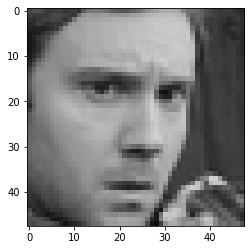

In [ ]:
plt.imshow(np.repeat(np.array(list(map(int, df['pixels'][0].split()))).reshape(48, 48, 1), 3, axis=-1))

In [ ]:
def split_data(df):
  train_df = df[df['usage'] == 'Training']
  val_df = df[df['usage'] == 'PublicTest']
  test_df = df[df['usage'] == 'PrivateTest']

  return train_df, val_df, test_df

In [ ]:
train_df, val_df, test_df = split_data(df)

In [ ]:
BATCH_SIZE = 64

In [ ]:
def data_process(df):
  df['pixels'] = df['pixels'].apply(lambda x: list(map(int, x.split())))
  df['pixels'] = df['pixels'].apply(lambda x: np.array(x).reshape(48, 48, 1))

  return df

In [ ]:
train_df = data_process(train_df)
val_df = data_process(val_df)
test_df = data_process(test_df)

In [ ]:
train_df.head()

,emotion,usage,pixels
0,0,Training,"[[[70], [80], [82], [72], [58], [58], [60], [6..."
1,0,Training,"[[[151], [150], [147], [155], [148], [133], [1..."
2,2,Training,"[[[231], [212], [156], [164], [174], [138], [1..."
3,4,Training,"[[[24], [32], [36], [30], [32], [23], [19], [2..."
4,6,Training,"[[[4], [0], [0], [0], [0], [0], [0], [0], [0],..."


In [ ]:
def get_data_gen(df):
  x = np.zeros((BATCH_SIZE, 48, 48, 1))
  y = np.zeros((BATCH_SIZE, 7))

  while True:
    df_random = df.sample(n=BATCH_SIZE)
    for i, idx in zip(range(BATCH_SIZE), df_random.index.tolist()):
      x[i, :, :, :] = df_random['pixels'][idx]/255.0
    y[:, :] = tf.keras.utils.to_categorical(df_random['emotion'], num_classes=7)

    yield x, y

In [ ]:
train_gen = get_data_gen(train_df)
val_gen = get_data_gen(val_df)
test_gen = get_data_gen(test_df)

In [ ]:
x, y = next(train_gen)
print('x shape: ', x.shape)
print('y shape: ', y.shape)

x shape:  (64, 48, 48, 1)
y shape:  (64, 7)


In [ ]:
image_input = Input(shape=(48,48,1))

x = Conv2D(64,(3,3), activation="relu")(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(512,(3,3),activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(256,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(512,activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

image_output = Dense(7,activation="softmax")(x)

model = Model(image_input,image_output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 128)       512   

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint("model_expr.h5", monitor='val_accuracy', save_weights_only=True, verbose=1)

In [ ]:
hist = model.fit(train_gen, epochs=100, validation_data=val_gen, steps_per_epoch=128,
          validation_steps=64, callbacks=[checkpoint, reduce_lr])

Epoch 1/100
128/128 [==============================] - 55s 35ms/step - loss: 2.8451 - accuracy: 0.1842 - val_loss: 2.1581 - val_accuracy: 0.2520

Epoch 00001: saving model to model_expr.h5
Epoch 2/100
128/128 [==============================] - 3s 27ms/step - loss: 2.2572 - accuracy: 0.2061 - val_loss: 2.4308 - val_accuracy: 0.1738

Epoch 00002: saving model to model_expr.h5
Epoch 3/100
128/128 [==============================] - 3s 27ms/step - loss: 2.0244 - accuracy: 0.2412 - val_loss: 1.8270 - val_accuracy: 0.1985

Epoch 00003: saving model to model_expr.h5
Epoch 4/100
128/128 [==============================] - 3s 27ms/step - loss: 1.8447 - accuracy: 0.2940 - val_loss: 2.0482 - val_accuracy: 0.2708

Epoch 00004: saving model to model_expr.h5
Epoch 5/100
128/128 [==============================] - 3s 27ms/step - loss: 1.7045 - accuracy: 0.3427 - val_loss: 1.5754 - val_accuracy: 0.3757

Epoch 00005: saving model to model_expr.h5
Epoch 6/100
128/128 [==============================] - 3s 2

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
model.save('model_e.h5')